In [29]:
import os
import json
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import importlib
from scripts.snap_reader import DiscReader, PlanetReader, PlanetSnap
import h5py
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def plot_planet_time_evolution(DIR):
    """
    Plot the time evolution of a planet's properties.
    """
    # Load the planet data
    planets = PlanetReader(DIR, base='planet')
    planets = planets.compute_planet_evo()

    R_start_groups = {}  # Group planets by their starting radius (R_start)

    # Group planets by their starting radius
    for p in planets:
        R_start = p.R[0]  # Assuming the first radius is the starting radius
        if R_start not in R_start_groups:
            R_start_groups[R_start] = []
        R_start_groups[R_start].append(p)

    # Sort the starting radii
    sorted_R_start = sorted(R_start_groups.keys())

    # Plot the properties of the planets
    plt.figure(figsize=(16, 12))  # Set the figure size

    for R_start in sorted_R_start:
        for p in R_start_groups[R_start]:
            # Plot total mass
            plt.subplot(311)
            plt.loglog(p.time, p.M / 317.8)
            
            # Plot core mass
            plt.subplot(312)
            plt.loglog(p.time, p.M_core)
            
            # Plot radius
            plt.subplot(313)
            plt.loglog(p.time, p.R,  label=f'$R_0$ = {p.R[0]:.2f} AU, $M_0$ = {p.M[0]:.2f} $M_\\oplus$')

    # Set titles, labels, and legends for each subplot
    plt.subplot(311)
    plt.title('Planet Evolution Over Time', fontsize=16)
    plt.ylabel('$M,[M_J]$', fontsize=14)
    plt.xlim(xmin=1e4)

    plt.subplot(312)
    plt.ylabel('$M_c,[M_\\oplus]$', fontsize=14)
    plt.xlim(xmin=1e4)

    plt.subplot(313)
    plt.xlabel('$t,[\\mathrm{yr}]$', fontsize=14)
    plt.ylabel('$R,[\\mathrm{au}]$', fontsize=14)
    plt.xlim(xmin=1e4)
    plt.legend(fontsize=10, loc='best',  ncol=3)  # Add legend for starting radius

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [31]:
def plot_disc_evolution(DIR, plot_name=None):
    """
    Plot the time evolution of a disc's properties with improved readability.
    """
    reader = DiscReader(DIR, 'disc')

    snaps = [0, 10, 50, 100, 200, 300]
    colors = plt.cm.viridis(np.linspace(0, 1, len(snaps)))  # Generate distinct colors

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Increase figure size
    axes = axes.flatten()

    # Store handles and labels for the gas/dust legend
    gas_dust_handles = []
    gas_dust_labels = []

    for i, n in enumerate(snaps):
        try:
            disc = reader[n]
        except KeyError:
            continue

        age = disc.time / 1e6  # Convert to Myr

        Sigma_G = disc.Sigma * (1 - disc.dust_frac.sum(0))
        Sigma_D = disc.Sigma * (disc.dust_frac)
        Stokes = (disc.grain_size / disc.Sigma) * np.pi / 2

        # Plot Gas and Dust Surface Density
        h1, = axes[0].loglog(disc.R, Sigma_G, label=f"{age:.1f} Myr", color=colors[i])
        h2, = axes[0].loglog(disc.R, Sigma_D.sum(0), '--', color=colors[i])
        
        if i == 0:  # Add labels for gas and dust once
            gas_dust_handles.extend([h1, h2])
            gas_dust_labels.extend(["Gas (solid)", "Dust (dashed)"])

        axes[0].set_ylabel(r'$\Sigma_\mathrm{G,D}$', fontsize=14)
        axes[0].set_ylim(ymin=1e-5)
        axes[0].set_title("Surface Density", fontsize=14)

        # Plot Temperature
        axes[1].loglog(disc.R, disc.T, label=f"{age:.1f} Myr", color=colors[i])
        axes[1].set_ylabel("Temperature (T)", fontsize=14)
        axes[1].set_title("Temperature Profile", fontsize=14)

        # Plot Stokes Number
        axes[2].loglog(disc.R, Stokes[1], label=f"{age:.1f} Myr", color=colors[i])
        axes[2].set_ylabel(r'$St$', fontsize=14)
        axes[2].set_title("Stokes Number", fontsize=14)

        # Plot Grain Size
        axes[3].loglog(disc.R, disc.grain_size[1], label=f"{age:.1f} Myr", color=colors[i])
        axes[3].set_ylabel(r'$a\ [\mathrm{cm}]$', fontsize=14)
        axes[3].set_title("Grain Size", fontsize=14)

    # Add axis labels
    for ax in axes:
        ax.set_xlabel("Radius (R)", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)

    # Add gas/dust legend in upper left corner of the first plot
    legend1 = axes[0].legend(gas_dust_handles, gas_dust_labels, loc="lower left", fontsize=10)
    axes[0].add_artist(legend1)

    axes[0].legend(title="Time Snapshots", loc="upper right", fontsize=10)

    if plot_name:
        fig.suptitle(plot_name, fontsize=16)

    plt.tight_layout()
    plt.show()

In [32]:

def plot_growth_tracks(DIR, separate_mass=False, plot_name=None):
    """
    Plot the growth tracks of planets in the simulation, with an option to separate initial mass groupings.
    """
    # Load the planet data 
    planets = PlanetReader(DIR, base='planet')
    planets = planets.compute_planet_evo()
    
    tf = {}
    for p in planets:
        if p.t_form[0] not in tf:
            tf[p.t_form[0]] = []
        tf[p.t_form[0]].append(p)

    keys = sorted(tf.keys())
    
    step = 250000  # Step interval for highlights
    tolerance = 50  # Tolerance in time matching

    # Group planets by initial mass if separate_mass is True
    if separate_mass:
        mass_groups = {}
        for t_form in keys:
            for p in tf[t_form]:
                if p.M[0] not in mass_groups:
                    mass_groups[p.M[0]] = []
                mass_groups[p.M[0]].append(p)

        for mass, group in mass_groups.items():
            plt.figure(figsize=(10, 6))  # New figure for each mass group
            if plot_name:
                plt.title(f'Planet Growth Tracks (Initial Mass: {mass:.2f} $M_\\oplus$)'+' '+plot_name, fontsize=16)
            else:
                plt.title(f'Planet Growth Tracks (Initial Mass: {mass:.2f} $M_\\oplus$)', fontsize=16)
            _plot_tracks(group, step, tolerance)
            plt.show()
    else:
        plt.figure(figsize=(10, 6))  # Single figure for all tracks
        _plot_tracks(planets, step, tolerance)
        if plot_name:
            plt.title(plot_name, fontsize=16)
        plt.show()

def _plot_tracks(planets, step, tolerance):
    """Helper function to plot growth tracks for a given set of planets."""
    planet_legend_entries = []  # Store legend entries for planets
    
    for p in planets:
        total_mass_line, = plt.loglog(p.R, p.M, '--')
        core_mass_line, = plt.loglog(p.R, p.M_core, color=total_mass_line.get_color())
        line_color = total_mass_line.get_color()

        target_times = np.arange(0, np.max(p.time) + step, step)
        closest_indices = [np.abs(p.time - t).argmin() for t in target_times]
        filtered_indices = [i for i in closest_indices if abs(p.time[i] - round(p.time[i] / step) * step) <= tolerance]
        plt.scatter(p.R[filtered_indices], p.M[filtered_indices], color=line_color, marker='o')

        planet_legend_entries.append(Line2D([0], [0], color=line_color, linestyle='-',
                                            label=rf"$R_0$ = {p.R[0]:.2f} AU, $M_0$ = {p.M[0]:.2f} $M_\oplus$"))
    
    plt.ylabel(r'$M\ [M_\oplus]$', fontsize=14)
    plt.xlabel(r'$R\ [\mathrm{au}]$', fontsize=14)
    
    line_style_legend = plt.legend(
        handles=[
            Line2D([0], [0], linestyle='--', color='black', label=r'Total Planet Mass'),
            Line2D([0], [0], linestyle='-', color='black', label=r'Core Planet Mass')
        ],
        loc='upper right', fontsize=10,
    )

    planet_legend = plt.legend(handles=planet_legend_entries, fontsize=10, loc='best', ncol=2)
    plt.gca().add_artist(line_style_legend)  # Ensure both legends appear
    plt.tight_layout()

In [33]:
def planetesimal_plot(DIR):
    """"
    "Plot the planetesimal distribution in the simulation.
    """
    reader = DiscReader(DIR, 'disc')

    snaps = [0, 10, 50, 100, 200, 300]
    colors = plt.cm.viridis(np.linspace(0, 1, len(snaps)))

    plt.figure(figsize=(12,8))  # Set the figure size

    for i, n in enumerate(snaps):
        try:
            disc = reader[n]
        except KeyError:
            continue

        age = disc.time / 1e6
        Sigma_D = disc.Sigma * (disc.dust_frac)

        Sigma_dust = Sigma_D[0]
        Sigma_pebble = Sigma_D[1]
        Sigma_planetesimal = Sigma_D[2]

        plt.loglog(disc.R, Sigma_planetesimal, label=f"{age:.1f} Myr", color=colors[i])
        plt.loglog(disc.R, Sigma_dust, linestyle=':', color=colors[i])
        plt.loglog(disc.R, Sigma_pebble, linestyle='--', color=colors[i])
    
    line_style_legend = plt.legend(
        handles=[
            Line2D([0], [0], linestyle='-', color='black', label=r'Planetesimal Surface Density'),
            Line2D([0], [0], linestyle='--', color='black', label=r'Pebble Surface Density'),
            Line2D([0], [0], linestyle=':', color='black', label=r'Dust Surface Density')
        ],
        loc='upper right', fontsize=10,
    )
    
    plt.gca().add_artist(line_style_legend)  # Ensure both legends appear

    plt.ylim(ymin=1e-10, ymax=1e2)
    plt.ylabel(r'Dust Surface Density $\Sigma$', fontsize=14)
    plt.xlabel(r'Radius $R$', fontsize=14)
    plt.title('Planetesimal and Dust Distribution Over Time', fontsize=16)
    plt.legend(title="Time Snapshots", loc="lower left", fontsize=10)
    plt.tight_layout()
    plt.grid()
    plt.show()

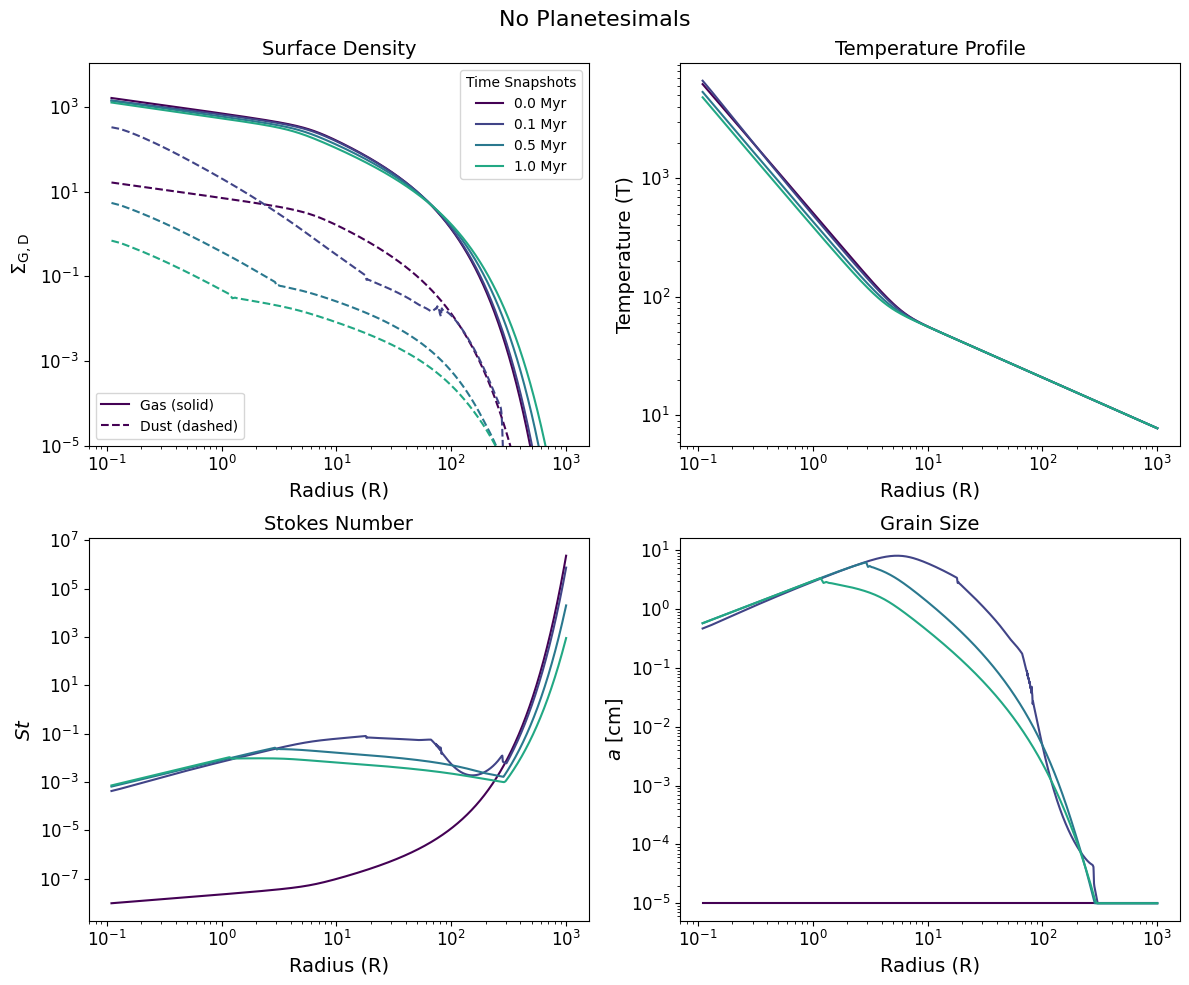

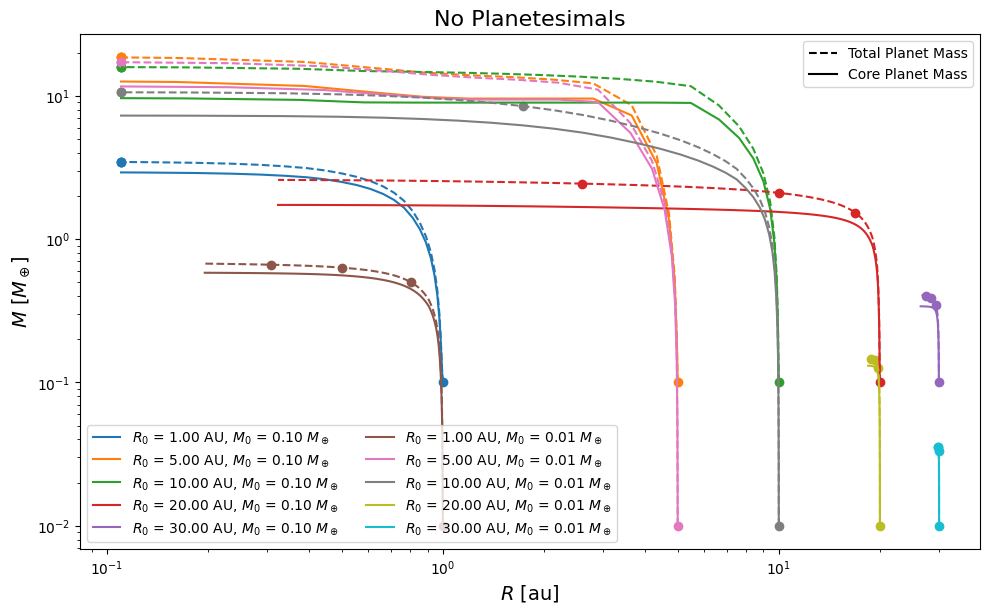

In [34]:
sys.path.append(os.path.abspath(os.path.join('..', 'DiscEvolution')))
DIR = 'planet_formation_scripts/output_planet'

#plot_planet_time_evolution(DIR)
plot_disc_evolution(DIR, plot_name='No Planetesimals')
plot_growth_tracks(DIR, plot_name='No Planetesimals')

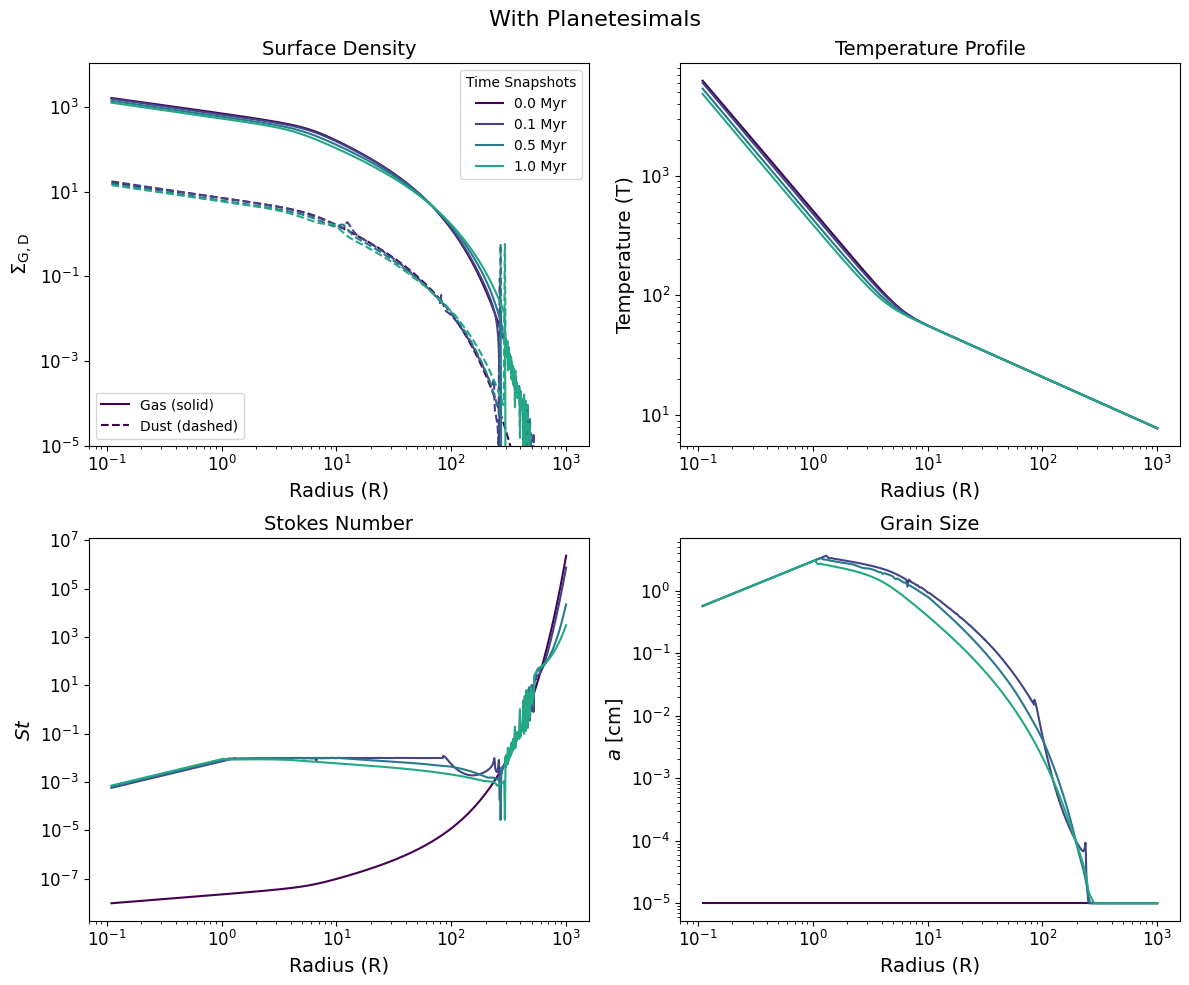

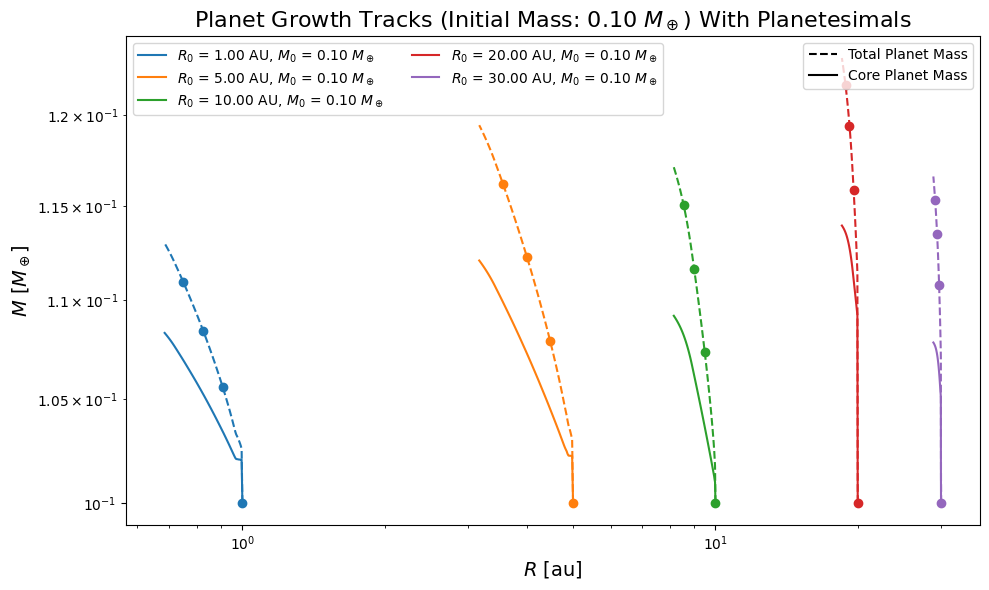

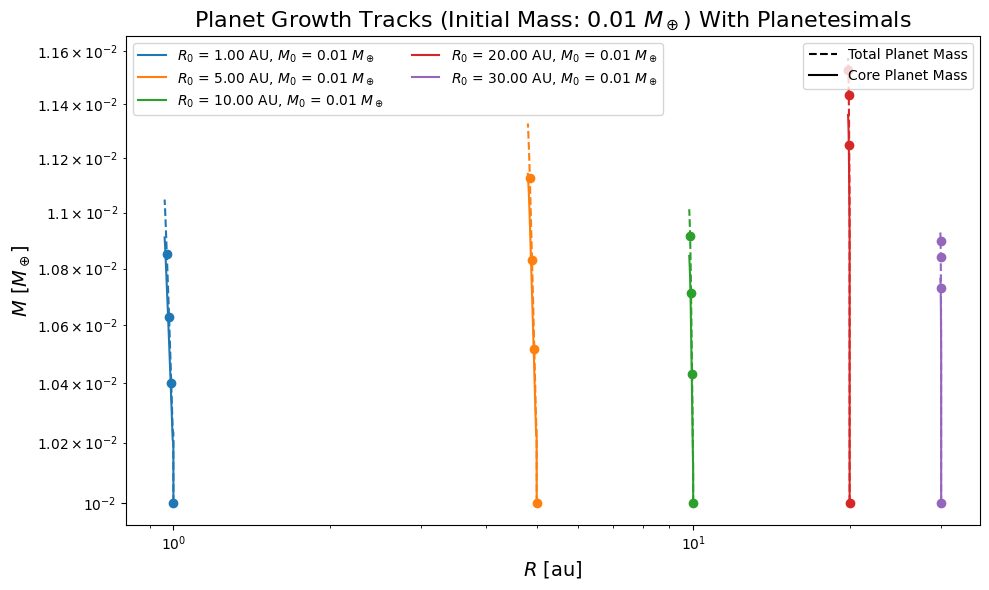

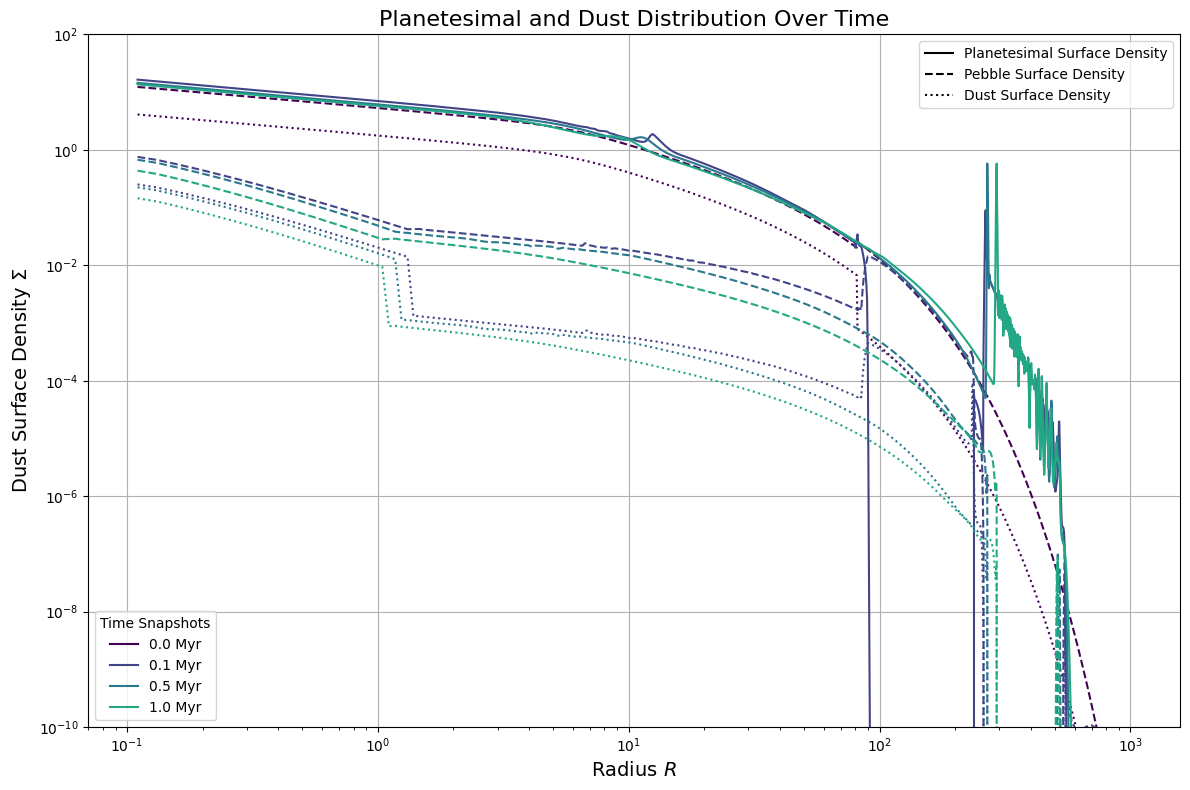

In [37]:
sys.path.append(os.path.abspath(os.path.join('..', 'DiscEvolution')))
DIR = 'planet_formation_scripts/output_planetesimals'

#plot_planet_time_evolution(DIR)
plot_disc_evolution(DIR, plot_name='With Planetesimals')
plot_growth_tracks(DIR, separate_mass=True, plot_name='With Planetesimals')
planetesimal_plot(DIR)

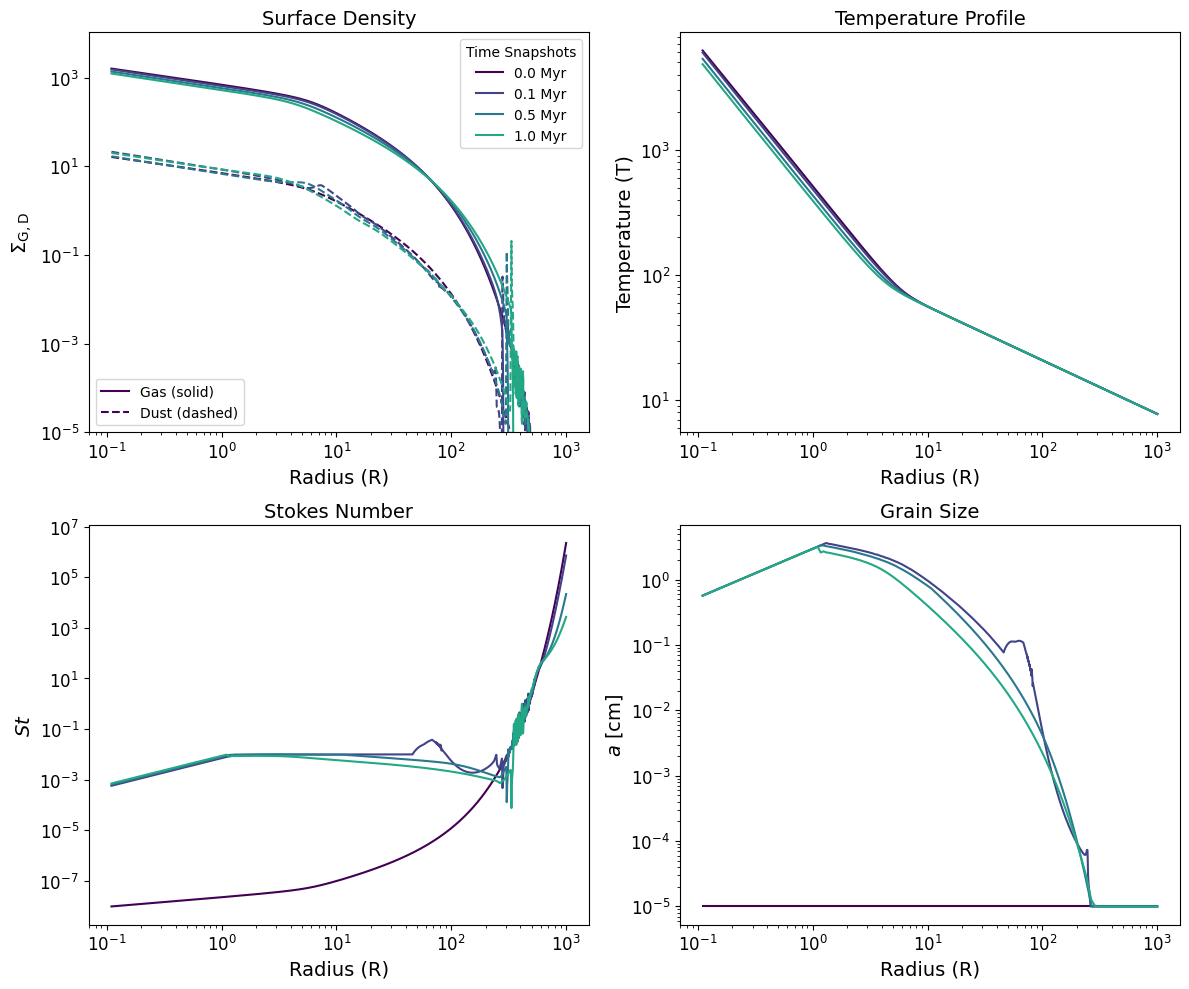

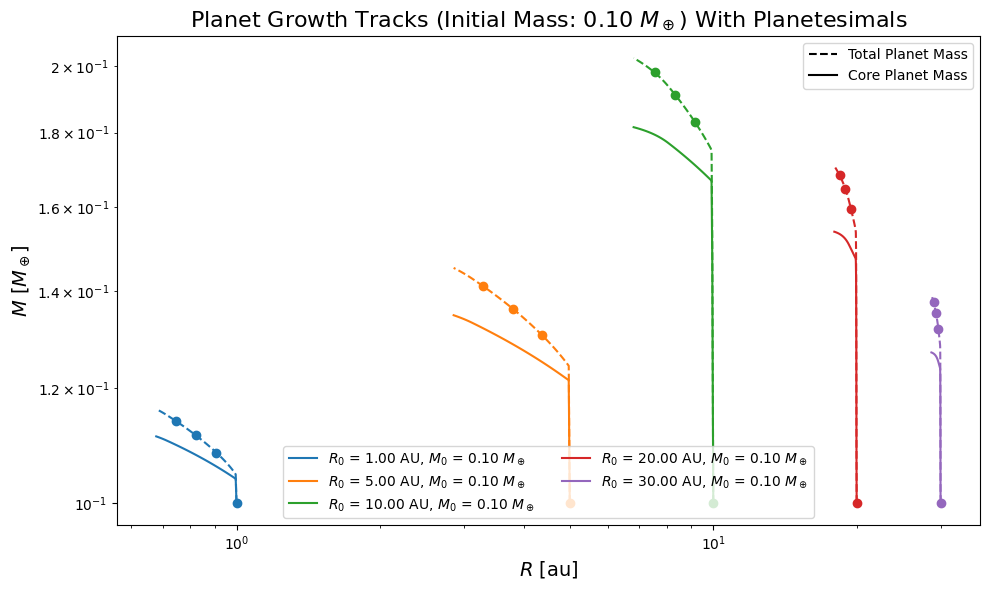

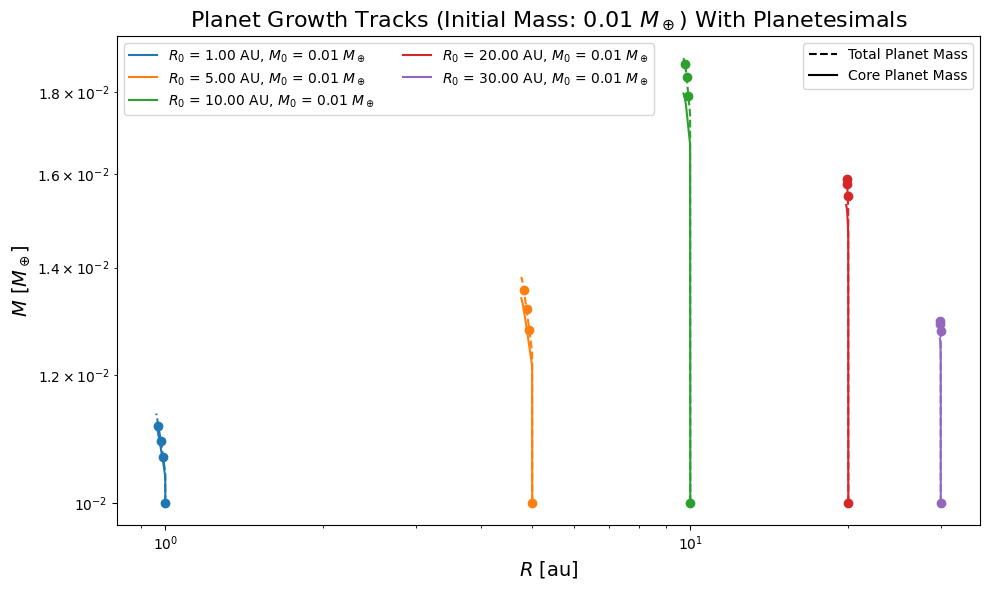

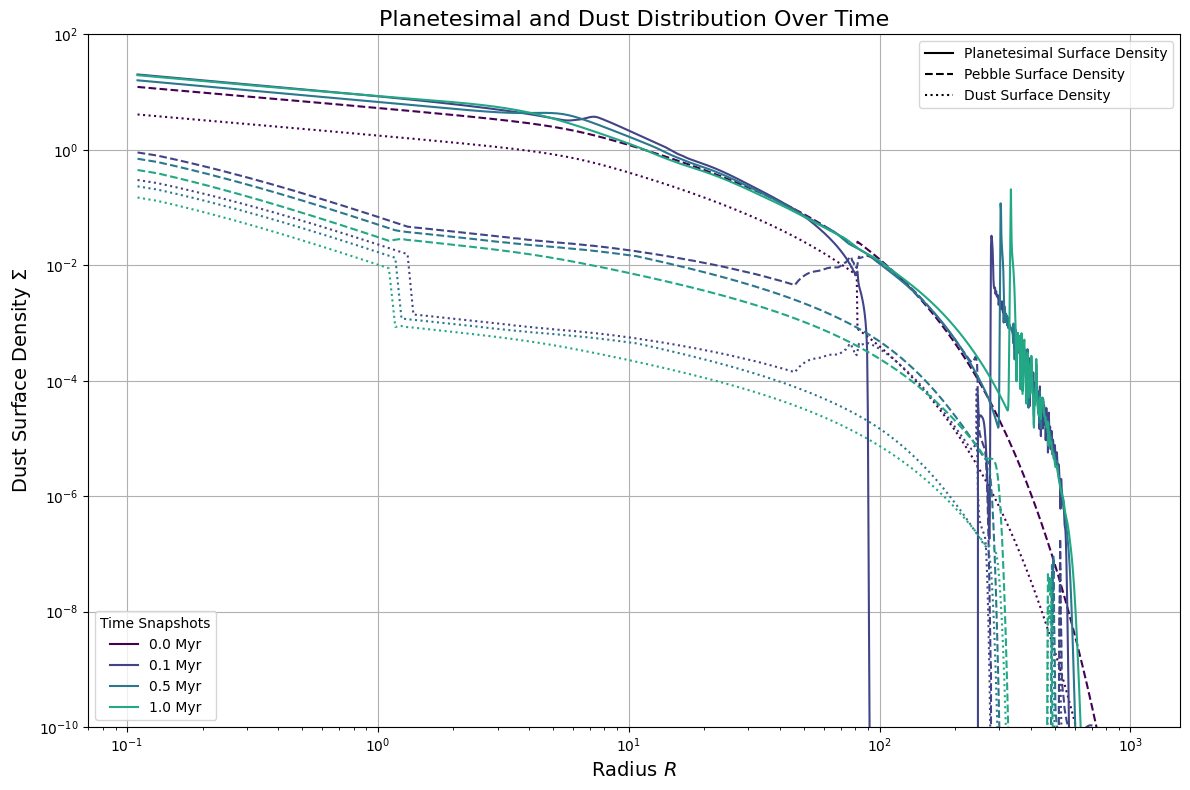

In [38]:
sys.path.append(os.path.abspath(os.path.join('..', 'DiscEvolution')))
DIR = 'planet_formation_scripts/output_planetesimals_eff_0.01'

#plot_planet_time_evolution(DIR)
plot_disc_evolution(DIR)
plot_growth_tracks(DIR, separate_mass=True, plot_name='With Planetesimals')
planetesimal_plot(DIR)